# Snyk Vulnerability Dashboard — Multi-Organization Analysis

This notebook provides a data visualization framework for analyzing vulnerability data across multiple Snyk organizations. The dataset is **synthetic** and mirrors the structure of Snyk's Reporting API / `snyk-issues-to-csv` exports.

**Dataset characteristics:**
- 5 Snyk Organizations (Platform Engineering, Consumer Web, Internal Tools, Data Services, Mobile & API Gateway)
- 20 Projects across PHP, Node.js, Python, Elixir, Java, Go, HCL, and container ecosystems
- SCA, SAST, and IaC scan types
- ~450 vulnerability and license issues

**To use with real data:** Replace `snyk_vulnerability_dataset.csv` with your actual Snyk export. The column names align with the Snyk Reporting API v1 fields.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

# Snyk severity color palette (matches Snyk UI)
SEVERITY_COLORS = {'critical': '#AB1A1A', 'high': '#CE5019', 'medium': '#D68000', 'low': '#88879E'}
SEVERITY_ORDER = ['critical', 'high', 'medium', 'low']
STATUS_COLORS = {'open': '#CE5019', 'fixed': '#28A745', 'ignored': '#88879E'}

df = pd.read_csv('snyk_vulnerability_dataset.csv')
df['introduced_date'] = pd.to_datetime(df['introduced_date'])
df['discovered_date'] = pd.to_datetime(df['discovered_date'])
df['resolved_date'] = pd.to_datetime(df['resolved_date'], errors='coerce')
df['severity'] = pd.Categorical(df['severity'], categories=SEVERITY_ORDER, ordered=True)

print(f"Loaded {len(df)} issues across {df['org_name'].nunique()} organizations and {df['project_name'].nunique()} projects")
print(f"Date range: {df['discovered_date'].min().date()} to {df['discovered_date'].max().date()}")


Matplotlib is building the font cache; this may take a moment.


Loaded 445 issues across 5 organizations and 20 projects
Date range: 2024-03-05 to 2026-03-09


## 1. Executive Summary — Risk Posture by Organization

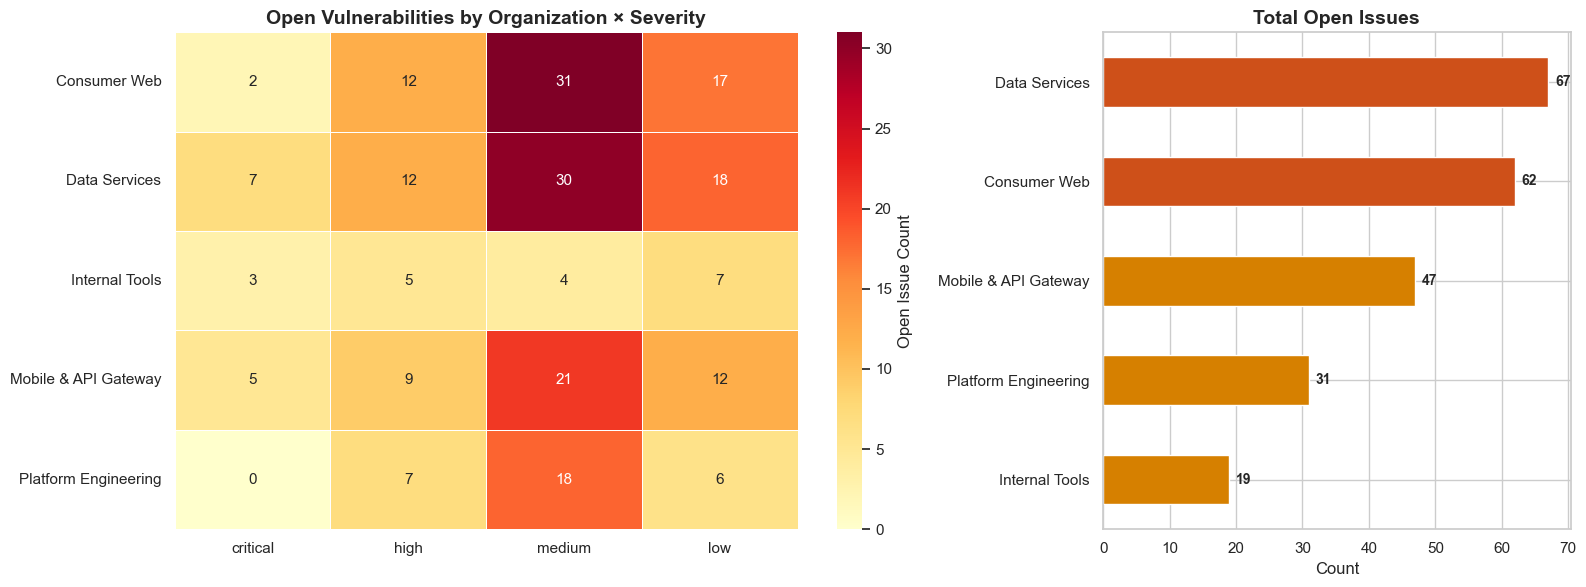

In [4]:
# Cross-org severity heatmap
pivot = df[df['status'] == 'open'].groupby(['org_name', 'severity']).size().unstack(fill_value=0)
pivot = pivot.reindex(columns=SEVERITY_ORDER)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1.2]})

# Heatmap
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd', linewidths=0.5,
            cbar_kws={'label': 'Open Issue Count'}, ax=axes[0])
axes[0].set_title('Open Vulnerabilities by Organization × Severity', fontweight='bold')
axes[0].set_ylabel('')
axes[0].set_xlabel('')

# Summary bar
org_totals = df[df['status'] == 'open'].groupby('org_name').size().sort_values(ascending=True)
colors = ['#CE5019' if v > org_totals.median() else '#D68000' for v in org_totals.values]
org_totals.plot(kind='barh', ax=axes[1], color=colors, edgecolor='white')
axes[1].set_title('Total Open Issues', fontweight='bold')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
for i, v in enumerate(org_totals.values):
    axes[1].text(v + 1, i, str(v), va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


## 2. Severity Distribution — All Issues

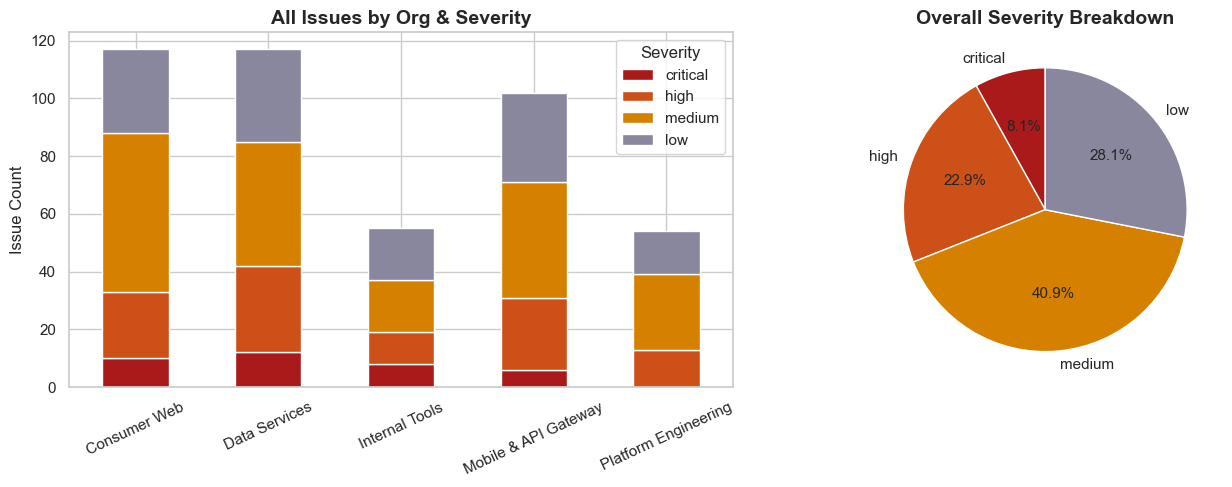

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked bar by org
severity_by_org = df.groupby(['org_name', 'severity']).size().unstack(fill_value=0)
severity_by_org = severity_by_org.reindex(columns=SEVERITY_ORDER)
severity_by_org.plot(kind='bar', stacked=True, ax=axes[0],
                     color=[SEVERITY_COLORS[s] for s in SEVERITY_ORDER], edgecolor='white')
axes[0].set_title('All Issues by Org & Severity', fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Issue Count')
axes[0].tick_params(axis='x', rotation=25)
axes[0].legend(title='Severity', bbox_to_anchor=(1.0, 1.0))

# Pie chart for overall severity
sev_counts = df['severity'].value_counts().reindex(SEVERITY_ORDER)
axes[1].pie(sev_counts, labels=sev_counts.index, colors=[SEVERITY_COLORS[s] for s in sev_counts.index],
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Overall Severity Breakdown', fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Vulnerability Discovery Trends Over Time

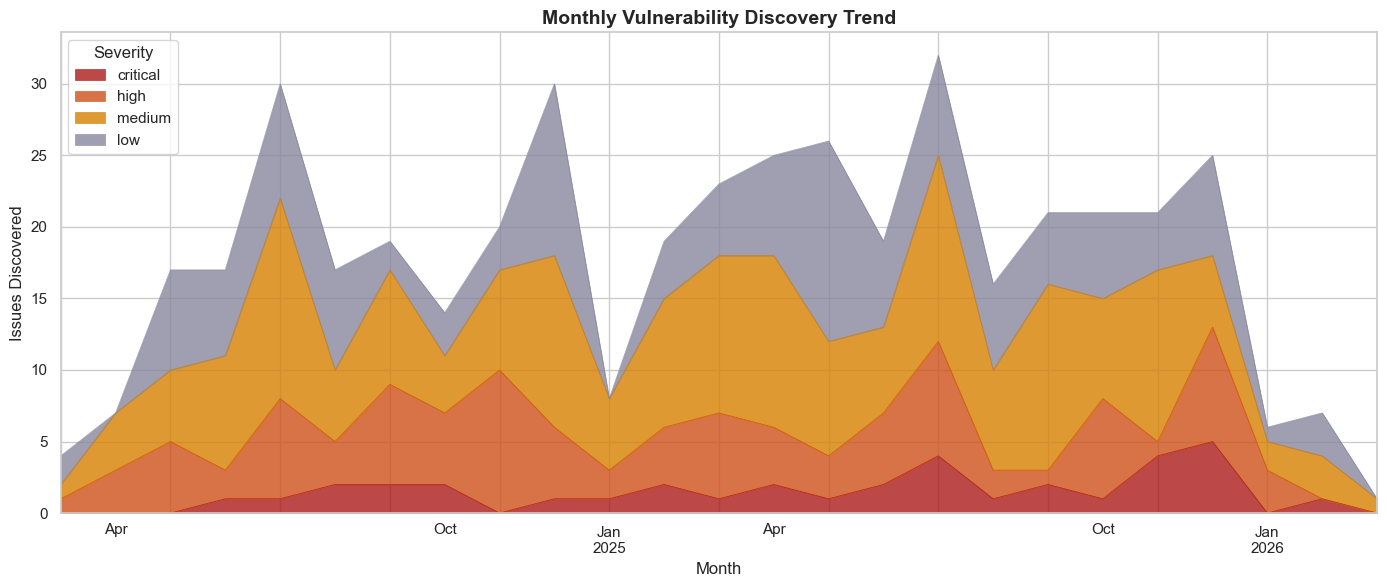

In [6]:
# Monthly discovery trend by severity
df['discovered_month'] = df['discovered_date'].dt.to_period('M')
monthly = df.groupby(['discovered_month', 'severity']).size().unstack(fill_value=0)
monthly = monthly.reindex(columns=SEVERITY_ORDER)
monthly.index = monthly.index.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 6))
monthly.plot(kind='area', stacked=True, ax=ax,
             color=[SEVERITY_COLORS[s] for s in SEVERITY_ORDER], alpha=0.8, linewidth=0.5)
ax.set_title('Monthly Vulnerability Discovery Trend', fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Issues Discovered')
ax.legend(title='Severity', loc='upper left')
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.tight_layout()
plt.show()


## 4. Scan Type Breakdown — SCA vs SAST vs IaC

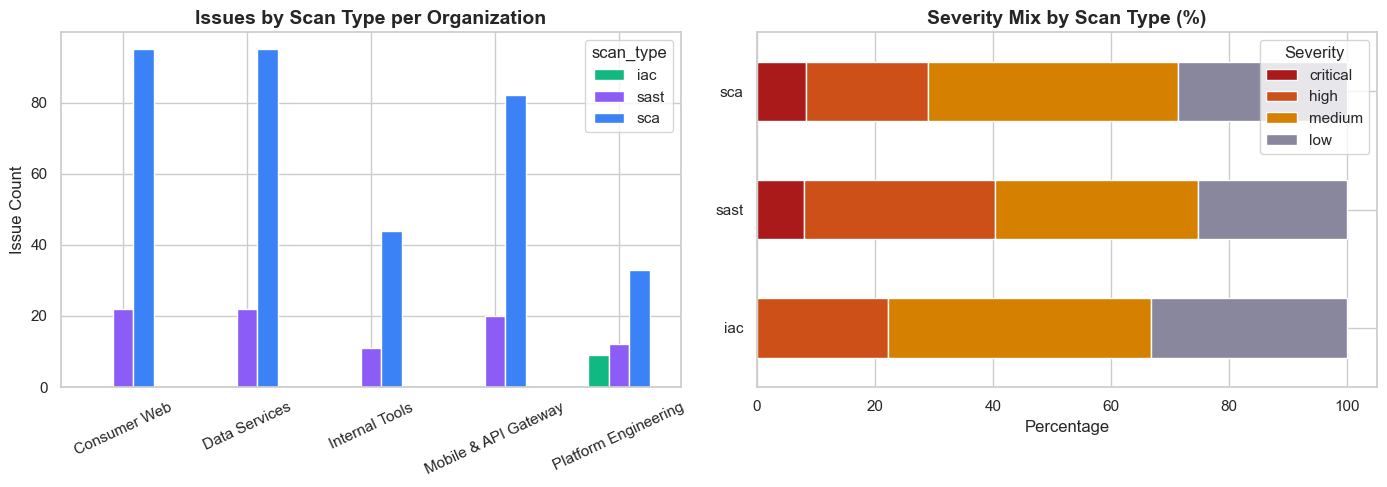

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scan type by org
scan_by_org = df.groupby(['org_name', 'scan_type']).size().unstack(fill_value=0)
scan_colors = {'sca': '#3B82F6', 'sast': '#8B5CF6', 'iac': '#10B981'}
scan_by_org.plot(kind='bar', ax=axes[0], color=[scan_colors.get(c, '#888') for c in scan_by_org.columns],
                 edgecolor='white')
axes[0].set_title('Issues by Scan Type per Organization', fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Issue Count')
axes[0].tick_params(axis='x', rotation=25)

# Scan type severity distribution
scan_sev = df.groupby(['scan_type', 'severity']).size().unstack(fill_value=0)
scan_sev = scan_sev.reindex(columns=SEVERITY_ORDER)
scan_sev_pct = scan_sev.div(scan_sev.sum(axis=1), axis=0) * 100
scan_sev_pct.plot(kind='barh', stacked=True, ax=axes[1],
                  color=[SEVERITY_COLORS[s] for s in SEVERITY_ORDER], edgecolor='white')
axes[1].set_title('Severity Mix by Scan Type (%)', fontweight='bold')
axes[1].set_xlabel('Percentage')
axes[1].set_ylabel('')
axes[1].legend(title='Severity')

plt.tight_layout()
plt.show()


## 5. Technology Stack Risk Profile

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Issues by language
lang_sev = df.groupby(['language', 'severity']).size().unstack(fill_value=0).reindex(columns=SEVERITY_ORDER)
lang_sev_sorted = lang_sev.loc[lang_sev.sum(axis=1).sort_values(ascending=False).index]
lang_sev_sorted.plot(kind='barh', stacked=True, ax=axes[0],
                     color=[SEVERITY_COLORS[s] for s in SEVERITY_ORDER], edgecolor='white')
axes[0].set_title('Vulnerabilities by Language/Ecosystem', fontweight='bold')
axes[0].set_xlabel('Issue Count')
axes[0].set_ylabel('')
axes[0].legend(title='Severity')

# CVSS score distribution by language (vulns only)
vulns = df[(df['issue_type'] == 'vuln') & (df['cvss_score'] > 0)]
lang_order = vulns.groupby('language')['cvss_score'].median().sort_values(ascending=False).index
sns.boxplot(data=vulns, y='language', x='cvss_score', order=lang_order,
            ax=axes[1], palette='YlOrRd_r', orient='h')
axes[1].set_title('CVSS Score Distribution by Language', fontweight='bold')
axes[1].set_xlabel('CVSS Score')
axes[1].set_ylabel('')
axes[1].axvline(x=7.0, color='red', linestyle='--', alpha=0.5, label='High threshold')
axes[1].axvline(x=9.0, color='darkred', linestyle='--', alpha=0.5, label='Critical threshold')
axes[1].legend()

plt.tight_layout()
plt.show()


## 6. Mean Time to Remediate (MTTR) — SLA Analysis

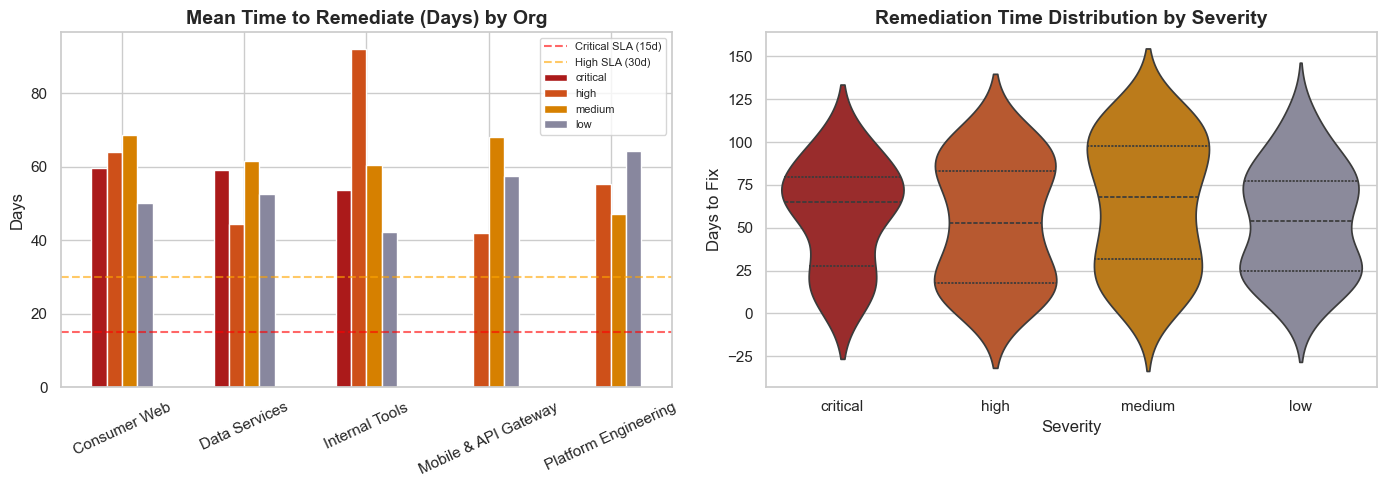


MTTR Summary (Days):
          mean  median   std
severity                    
critical  57.6    65.0  30.1
high      53.4    53.0  34.8
medium    63.9    68.0  37.6
low       53.5    54.0  31.8


In [9]:
fixed = df[(df['status'] == 'fixed') & (df['resolution_days'].notna())].copy()
fixed['resolution_days'] = pd.to_numeric(fixed['resolution_days'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MTTR by org and severity
mttr = fixed.groupby(['org_name', 'severity'])['resolution_days'].mean().unstack()
mttr = mttr.reindex(columns=SEVERITY_ORDER)
mttr.plot(kind='bar', ax=axes[0], color=[SEVERITY_COLORS[s] for s in SEVERITY_ORDER], edgecolor='white')
axes[0].set_title('Mean Time to Remediate (Days) by Org', fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Days')
axes[0].tick_params(axis='x', rotation=25)

# SLA bands
axes[0].axhline(y=15, color='red', linestyle='--', alpha=0.6, label='Critical SLA (15d)')
axes[0].axhline(y=30, color='orange', linestyle='--', alpha=0.6, label='High SLA (30d)')
axes[0].legend(fontsize=8)

# MTTR distribution
sns.violinplot(data=fixed, x='severity', y='resolution_days', order=SEVERITY_ORDER,
               palette=SEVERITY_COLORS, ax=axes[1], inner='quartile')
axes[1].set_title('Remediation Time Distribution by Severity', fontweight='bold')
axes[1].set_xlabel('Severity')
axes[1].set_ylabel('Days to Fix')

plt.tight_layout()
plt.show()

# Print summary stats
print("\nMTTR Summary (Days):")
print(fixed.groupby('severity')['resolution_days'].agg(['mean', 'median', 'std']).round(1).reindex(SEVERITY_ORDER).to_string())


## 7. Fixability & Exploit Maturity

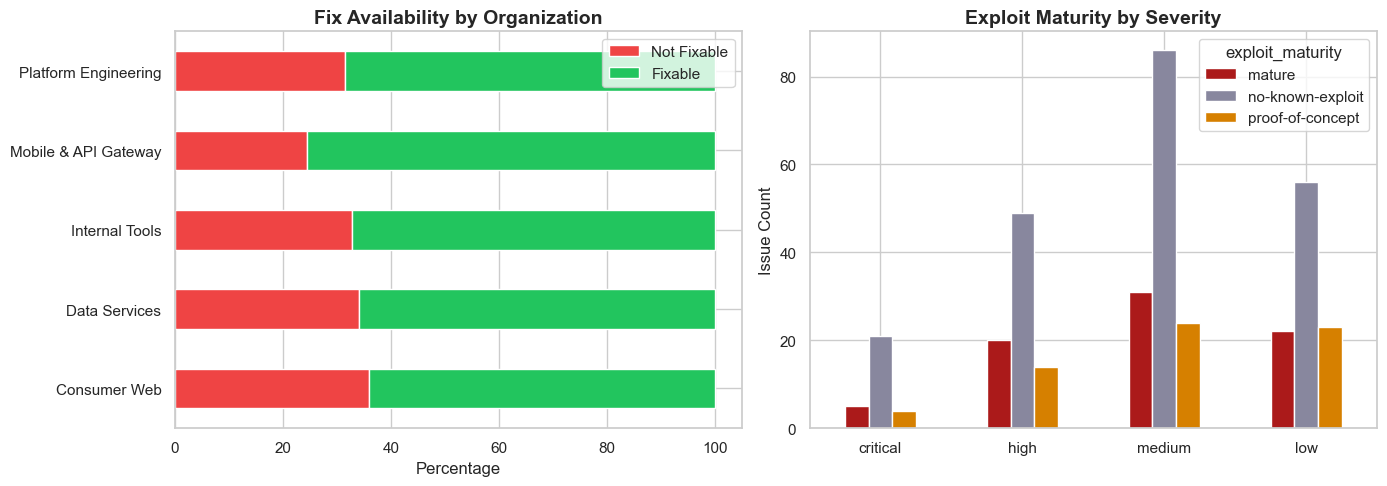

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fixability by org
fix_by_org = df.groupby(['org_name', 'is_fixable']).size().unstack(fill_value=0)
fix_by_org.columns = ['Not Fixable', 'Fixable']
fix_pct = fix_by_org.div(fix_by_org.sum(axis=1), axis=0) * 100
fix_pct.plot(kind='barh', stacked=True, ax=axes[0], color=['#EF4444', '#22C55E'], edgecolor='white')
axes[0].set_title('Fix Availability by Organization', fontweight='bold')
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('')
axes[0].legend(title='')

# Exploit maturity (vulns only)
exploit_data = df[(df['issue_type'] == 'vuln') & (df['exploit_maturity'] != '')]
exploit_counts = exploit_data.groupby(['severity', 'exploit_maturity']).size().unstack(fill_value=0)
exploit_colors = {'no-known-exploit': '#88879E', 'proof-of-concept': '#D68000', 'mature': '#AB1A1A'}
exploit_counts.plot(kind='bar', ax=axes[1],
                    color=[exploit_colors.get(c, '#888') for c in exploit_counts.columns], edgecolor='white')
axes[1].set_title('Exploit Maturity by Severity', fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('Issue Count')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


## 8. Top Vulnerability Types (CWE Analysis)

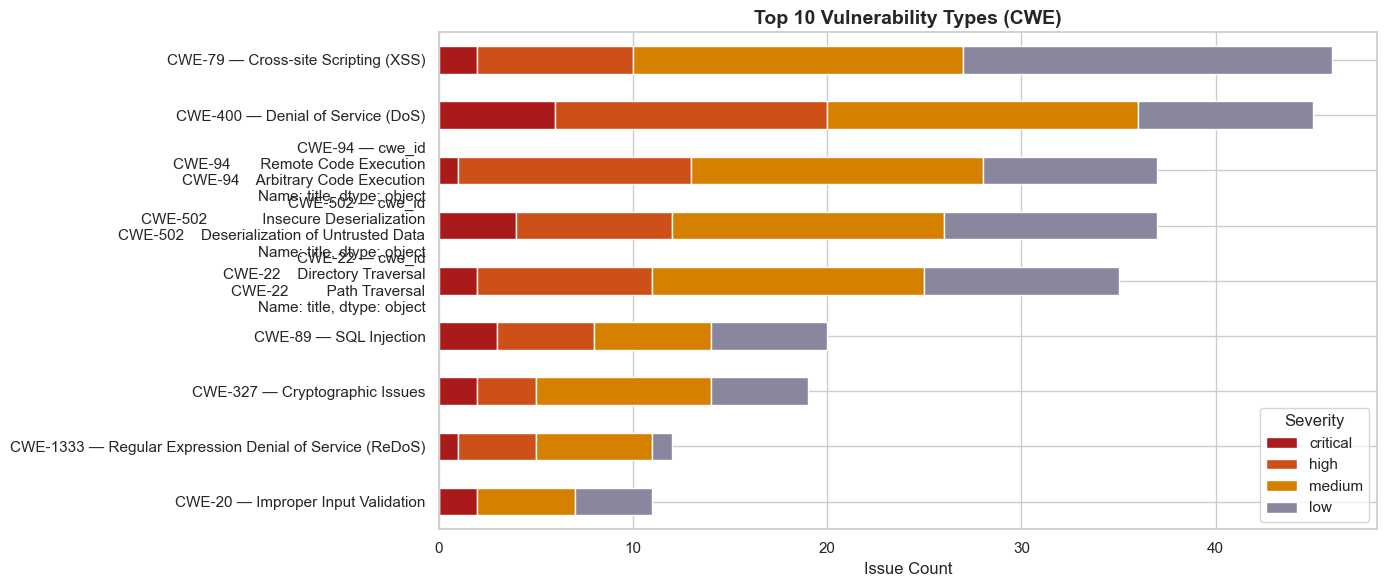

In [11]:
vulns_with_cwe = df[(df['cwe_id'] != '') & (df['issue_type'] == 'vuln')]

fig, ax = plt.subplots(figsize=(14, 6))

# Top 10 CWEs with severity breakdown
top_cwes = vulns_with_cwe.groupby(['cwe_id', 'title']).size().reset_index(name='count')
top_cwes = top_cwes.nlargest(10, 'count')
top_cwe_ids = top_cwes['cwe_id'].tolist()

cwe_sev = vulns_with_cwe[vulns_with_cwe['cwe_id'].isin(top_cwe_ids)]
cwe_pivot = cwe_sev.groupby(['cwe_id', 'severity']).size().unstack(fill_value=0).reindex(columns=SEVERITY_ORDER)
# Add title labels
cwe_labels = vulns_with_cwe[['cwe_id', 'title']].drop_duplicates().set_index('cwe_id')
cwe_pivot.index = [f"{idx} — {cwe_labels.loc[idx, 'title']}" if idx in cwe_labels.index else idx for idx in cwe_pivot.index]
cwe_pivot = cwe_pivot.loc[cwe_pivot.sum(axis=1).sort_values(ascending=True).index]

cwe_pivot.plot(kind='barh', stacked=True, ax=ax,
               color=[SEVERITY_COLORS[s] for s in SEVERITY_ORDER], edgecolor='white')
ax.set_title('Top 10 Vulnerability Types (CWE)', fontweight='bold')
ax.set_xlabel('Issue Count')
ax.set_ylabel('')
ax.legend(title='Severity')

plt.tight_layout()
plt.show()


## 9. Project Risk Scatter — Prioritization Matrix

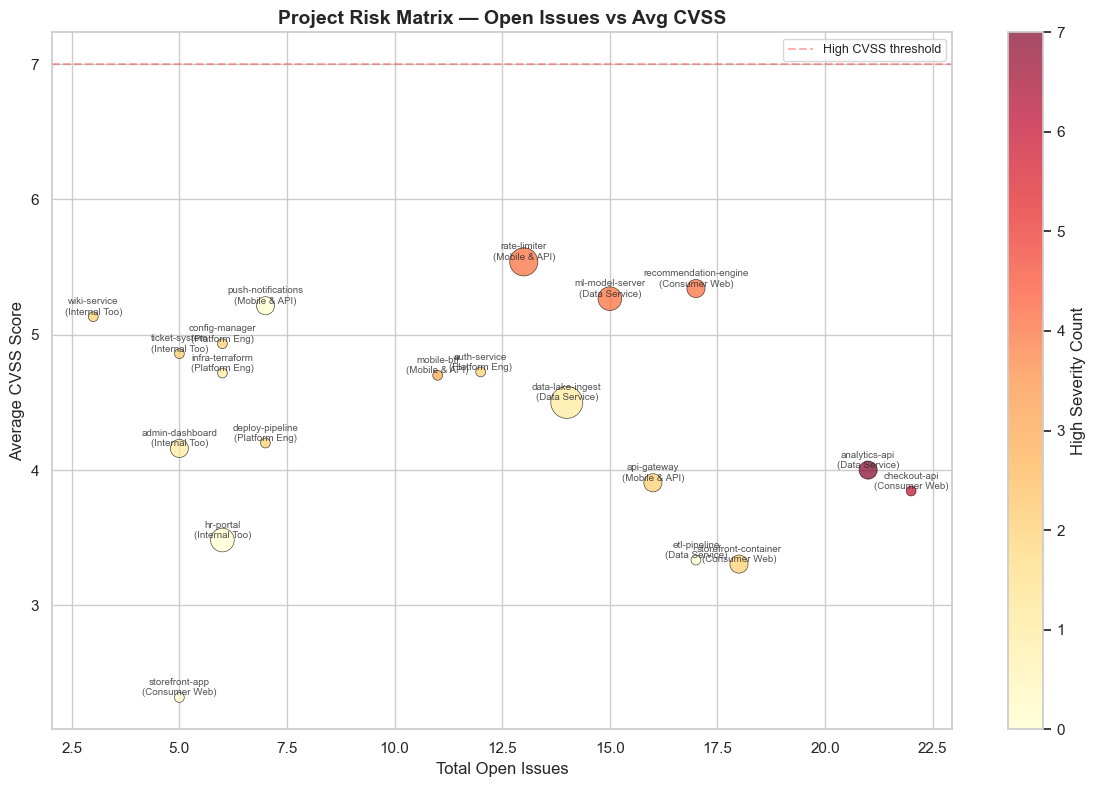

In [12]:
project_stats = df[df['status'] == 'open'].groupby(['project_name', 'org_name']).agg(
    total_open=('issue_id', 'count'),
    avg_cvss=('cvss_score', 'mean'),
    critical_count=('severity', lambda x: (x == 'critical').sum()),
    high_count=('severity', lambda x: (x == 'high').sum()),
).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    project_stats['total_open'],
    project_stats['avg_cvss'],
    s=project_stats['critical_count'] * 120 + 50,
    c=project_stats['high_count'],
    cmap='YlOrRd',
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5,
)

# Label each point
for _, row in project_stats.iterrows():
    ax.annotate(f"{row['project_name']}\n({row['org_name'][:12]})",
                (row['total_open'], row['avg_cvss']),
                fontsize=7, ha='center', va='bottom', alpha=0.8)

plt.colorbar(scatter, label='High Severity Count')
ax.set_title('Project Risk Matrix — Open Issues vs Avg CVSS', fontweight='bold')
ax.set_xlabel('Total Open Issues')
ax.set_ylabel('Average CVSS Score')
ax.axhline(y=7.0, color='red', linestyle='--', alpha=0.3, label='High CVSS threshold')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()


## 10. Next Steps — Connecting Real Data

### Swap in real Snyk data
Replace the CSV with output from any of these sources:
1. **Snyk Reporting API v1** — `GET /v1/reporting/issues/latest`
2. **`snyk-issues-to-csv`** — [github.com/snyk-labs/snyk-issues-to-csv](https://github.com/snyk-labs/snyk-issues-to-csv)  
3. **Snyk UI CSV export** — Reports → Issues Detail → Download CSV

### Add other vulnerability scanner data
Normalize outputs from other tools into the same schema:
- **OWASP Dependency-Check** → map `dependency`, `cve`, `cvssScore`, `severity`
- **Trivy** → map `VulnerabilityID`, `PkgName`, `Severity`, `CVSS`
- **SonarQube/SonarCloud** → map `rule`, `severity`, `component`, `type`
- **Sonatype Nexus Lifecycle** → map `policyViolations` → severity, component

### Extend this notebook
- Add **SLA compliance tracking** with your org's remediation SLAs
- Build a **risk scoring model** weighted by exploit maturity + asset criticality
- Create **burndown charts** tracking remediation velocity per sprint
- Add **OWASP Top 10 mapping** using the CWE → OWASP category crosswalk
